In [11]:

import re

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchtext
from sklearn.metrics import accuracy_score

from utils.data import DatasetIMDB, DatasetDBpedia, DatasetLM1B, get_imdb_data
from utils.train import train, get_all_prediction
from utils.models import TransPerformer, Contextualiser

# Embedding

In [12]:
EMBEDDING_DIM = 50
word2id, embeddings, train_ds_imdb_tmp, test_ds_imdb_tmp = get_imdb_data(embedding_size=EMBEDDING_DIM)
id2word = {value:key for key,value in word2id.items() }

In [13]:
def collate_fn(samples):

    global word2id
    PAD_IX = word2id["__PAD__"]
    lenMax = np.max([len(e) for e, _ in samples])
    res = []
    targets = []

    for sample, target in samples:
        pads = torch.full((lenMax-len(sample),), PAD_IX, dtype=torch.int)
        res.append(torch.cat((sample, pads), 0))
        targets.append(target)

    return torch.stack(res).long(), torch.tensor(targets)

# IMDB data

In [14]:
train_ds_imdb, test_ds_imdb = DatasetIMDB(train_ds_imdb_tmp), DatasetIMDB(test_ds_imdb_tmp)

# DBpedia data

In [ ]:
train_ds_dbpedia_tmp, test_ds_dbpedia_tmp = torchtext.datasets.DBpedia(ngrams=1)

In [ ]:
train_ds_dbpedia, test_ds_dbpedia = DatasetDBpedia(train_ds_dbpedia_tmp, word2id), DatasetDBpedia(test_ds_dbpedia_tmp, word2id)

# LM1B data

In [7]:
path_data_lm1b = "../data/sample"

In [9]:
ds_lm1b = DatasetLM1B(path_data_lm1b, word2id)

## Création train_dataset sample

In [15]:
class SampleDataset(Dataset):

    def __init__(self, dataset, nb_sample):
        self.data = []
        indices = np.random.choice(len(dataset), size=nb_sample, replace=False)
        for ind in indices:
            self.data.append(dataset[ind])

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)



In [16]:
train_dataset_sample, test_dataset_sample = SampleDataset(train_ds_imdb, 200), SampleDataset(test_ds_imdb, 200)
#train_dataset_sample, test_dataset_sample = SampleDataset(train_ds_dbpedia, 200), SampleDataset(test_ds_dbpedia, 200)
#train_dataset_sample, test_dataset_sample = SampleDataset(ds_lm1b, 200), SampleDataset(ds_lm1b, 200)

In [17]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset_sample, collate_fn=collate_fn, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset_sample, collate_fn=collate_fn, shuffle=True, batch_size=BATCH_SIZE)
criterion = nn.CrossEntropyLoss()

# Modèles & Paramètres

In [18]:
NB_CLASSE = 2
CLASSIF_INTER_DIM = 10
L = 3
NUM_SAMPLE = False #valeur par défaut pour désactiver l'approximation du softmax
MAX_LEN = False #valeur par défaut pour désactiver le positinal encodding
#MAX_LEN = max([data.shape[1] for data,_ in train_loader])

# Transformer/Performer use

In [19]:
context_model = nn.Identity()#Contextualiser(input_size=EMBEDDING_DIM, hidden_size=EMBEDDING_DIM)

query_model = [nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=True) for _ in range(L)]
key_model = [nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=True) for _ in range(L)]
value_model = [nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=True) for _ in range(L)]

mlp = [nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=True) for _ in range(L)]

classifier = nn.Sequential( nn.Linear(EMBEDDING_DIM, CLASSIF_INTER_DIM, bias=True),
                            nn.ReLU(),
                            nn.Linear(CLASSIF_INTER_DIM, NB_CLASSE, bias=True) )

In [22]:
model = TransPerformer(embeddings=embeddings, word2id=word2id, nb_classe=NB_CLASSE, \
                L=L, emb_dim=EMBEDDING_DIM, max_len=MAX_LEN, num_sample=NUM_SAMPLE, \
                norm1=True, norm2=True, \
                context_model=context_model, classifier=classifier, mlp=mlp, \
                query_model=query_model, key_model=key_model, value_model=value_model)

In [23]:
optimizer = torch.optim.Adam(params=model.parameters())
nb_step = 200
nb_step_val = 20
interval_step_val = 40

train_loss, test_loss = train(train_loader, test_loader, model, optimizer, criterion, \
                                        nb_step=nb_step, nb_step_val=nb_step_val, interval_step_val=interval_step_val,\
                                        verbose=True, path="checkpointQ1.pt", path_early_stopping="bestParamsQ1.pt")

100%|██████████| 200/200 [02:06<00:00,  1.58it/s]EarlyStopping counter: 2 out of 20



In [24]:
res = get_all_prediction(model, train_loader, True)
accuracy_score(res[1], res[0])

100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


0.82

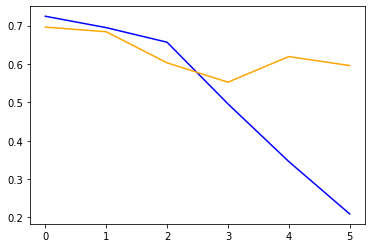

In [26]:
plt.plot(range(len(train_loss)), train_loss, color="blue")
plt.plot(range(len(test_loss)), test_loss, color="orange")